In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv
/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv


In [12]:
# Kaggle Summer Analytics Hackathon 
# Problem: NDVI-based Land Cover Classification
# ==============================================
# 1. IMPORT LIBRARIES
# ==============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [13]:
train = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")

   Unnamed: 0  ID  class  20150720_N  20150602_N  20150517_N  20150501_N  \
0           0   1  water    637.5950     658.668   -1882.030    -1924.36   
1           1   2  water    634.2400     593.705   -1625.790    -1672.32   
2           3   4  water     58.0174   -1599.160         NaN    -1052.63   
3           4   5  water     72.5180         NaN     380.436    -1256.93   
4           7   8  water   1136.4400         NaN         NaN     1647.83   

   20150415_N  20150330_N  20150314_N  ...  20140610_N  20140525_N  \
0     997.904   -1739.990     630.087  ...         NaN   -1043.160   
1     914.198    -692.386     707.626  ...         NaN    -933.934   
2         NaN   -1564.630         NaN  ...    -1025.88     368.622   
3     515.805   -1413.180    -802.942  ...    -1813.95     155.624   
4    1935.800         NaN    2158.980  ...     1535.00    1959.430   

   20140509_N  20140423_N  20140407_N  20140322_N  20140218_N  20140202_N  \
0   -1942.490     267.138         NaN        

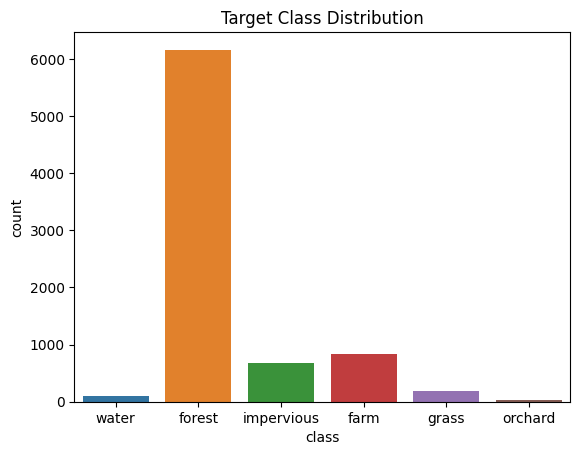

In [18]:
# Check basic info
print(train.head())
print(train.info())

# ==============================================
# 3. EDA (Exploratory Data Analysis)
# ==============================================

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Unique labels:", train['class'].unique())

# Class distribution
sns.countplot(x='class', data=train)
plt.title("Target Class Distribution")
plt.show()

# ==============================================




In [19]:
print(train.columns)


Index(['Unnamed: 0', 'ID', 'class', '20150720_N', '20150602_N', '20150517_N',
       '20150501_N', '20150415_N', '20150330_N', '20150314_N', '20150226_N',
       '20150210_N', '20150125_N', '20150109_N', '20141117_N', '20141101_N',
       '20141016_N', '20140930_N', '20140813_N', '20140626_N', '20140610_N',
       '20140525_N', '20140509_N', '20140423_N', '20140407_N', '20140322_N',
       '20140218_N', '20140202_N', '20140117_N', '20140101_N'],
      dtype='object')


In [29]:
# ==============================================
# 4. DATA PREPROCESSING
# ==============================================

# Features and target
X = train.drop(columns=["ID", "class"])
y = train["class"]

In [31]:
# Fill missing values with column mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)


In [32]:
# Test features
X_test_final = test.drop(columns=["ID"])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (NDVI values may have different scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)


In [33]:
# ==============================================
# 5. BASELINE MODEL (RANDOM FOREST)
# ==============================================

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_val_scaled)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


Random Forest Accuracy: 0.973125
[[ 162    0    0    6    0    0]
 [   0 1231    0    0    0    1]
 [   5    0   26    8    0    0]
 [  17    0    0  117    0    0]
 [   4    0    0    0    2    0]
 [   0    1    0    1    0   19]]
              precision    recall  f1-score   support

        farm       0.86      0.96      0.91       168
      forest       1.00      1.00      1.00      1232
       grass       1.00      0.67      0.80        39
  impervious       0.89      0.87      0.88       134
     orchard       1.00      0.33      0.50         6
       water       0.95      0.90      0.93        21

    accuracy                           0.97      1600
   macro avg       0.95      0.79      0.84      1600
weighted avg       0.97      0.97      0.97      1600



In [35]:
X_train_scaled.shape, y_train.shape

((6400, 28), (6400,))

In [36]:
from sklearn.preprocessing import LabelEncoder

# Create label encoder object
le = LabelEncoder()

# Fit and transform y_train and y_val
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)


In [39]:
# ==============================================
# 6. ADVANCED MODEL (XGBoost)
# ==============================================

xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train_scaled, y_train_encoded)
y_pred_xgb = xgb.predict(X_val_scaled)

# Decode predicted labels
y_pred_labels = le.inverse_transform(y_pred_xgb)

# Now both y_val and y_pred_labels are string labels
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_labels))
print(confusion_matrix(y_val, y_pred_labels))
print(classification_report(y_val, y_pred_labels))


XGBoost Accuracy: 0.981875
[[ 161    0    0    7    0    0]
 [   0 1231    0    0    0    1]
 [   2    0   30    7    0    0]
 [   9    0    0  125    0    0]
 [   2    0    0    0    4    0]
 [   0    0    0    1    0   20]]
              precision    recall  f1-score   support

        farm       0.93      0.96      0.94       168
      forest       1.00      1.00      1.00      1232
       grass       1.00      0.77      0.87        39
  impervious       0.89      0.93      0.91       134
     orchard       1.00      0.67      0.80         6
       water       0.95      0.95      0.95        21

    accuracy                           0.98      1600
   macro avg       0.96      0.88      0.91      1600
weighted avg       0.98      0.98      0.98      1600



In [43]:
# 7. FINAL TRAINING ON FULL DATA
# ==============================================

# Fit on full data
X_full_scaled = scaler.fit_transform(X)
xgb_final = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
# Encode full y
y_encoded = le.transform(y)

# Fit the model
xgb_final.fit(X_full_scaled, y_encoded)


# Predict on test data
final_predictions = xgb_final.predict(X_test_scaled)


In [44]:
# ==============================================
# 8. SUBMISSION FILE
# ==============================================

submission = pd.DataFrame({
    'ID': test['ID'],
    'class': final_predictions
})

submission.to_csv("submission.csv", index=False)
print("Submission file created!")

# ==============================================
# END OF PIPELINE
# ==============================================

Submission file created!
